In [3]:
import fastbook

In [4]:
from fastbook import *
from utils import *
from fastai.vision.widgets import *

In [3]:
#Gathering Data

In [6]:
path = Path('vehicletypes')

In [53]:
vehicle_type = 'car', 'truck', 'bus', 'aeroplane', 'ship'
path = Path('vehicletypes')

if not path.exists():
    path.mkdir()

for o in vehicle_type:
    print('Collecting: ', o)
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_ddg(o, max_n = 200)
    download_images(dest, urls=results)


Collecting:  car
Collecting:  truck
Collecting:  bus
Collecting:  aeroplane
Collecting:  ship


In [7]:
fns = get_image_files(path)
fns

(#1058) [Path('vehicletypes/aeroplane/00000000.jpg'),Path('vehicletypes/aeroplane/00000001.jpg'),Path('vehicletypes/aeroplane/00000002.jpg'),Path('vehicletypes/aeroplane/00000003.jpg'),Path('vehicletypes/aeroplane/00000004.jpg'),Path('vehicletypes/aeroplane/00000005.jpg'),Path('vehicletypes/aeroplane/00000006.jpg'),Path('vehicletypes/aeroplane/00000007.jpg'),Path('vehicletypes/aeroplane/00000007.png'),Path('vehicletypes/aeroplane/00000008.png')...]

In [10]:
#Unlinking Corrupt images from the path

In [55]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be ide

(#21) [Path('vehicletypes/car/00000117.jpg'),Path('vehicletypes/car/00000159.jpg'),Path('vehicletypes/truck/00000003.jpg'),Path('vehicletypes/truck/00000056.jpg'),Path('vehicletypes/truck/00000073.jpeg'),Path('vehicletypes/truck/00000087.jpg'),Path('vehicletypes/truck/00000123.jpg'),Path('vehicletypes/truck/00000127.jpg'),Path('vehicletypes/truck/00000133.jpg'),Path('vehicletypes/truck/00000154.jpg')...]

In [56]:
failed.map(Path.unlink)

(#21) [None,None,None,None,None,None,None,None,None,None...]

In [1]:
print('hello')

hello


In [18]:
#Making datablock for our data

In [9]:
vehicles_dataset = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [20]:
#Loading our data into dataloaders

In [58]:
dls = vehicles_dataset.dataloaders(path)

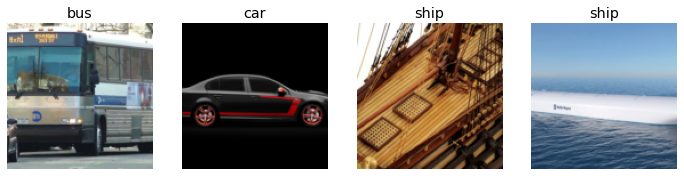

In [59]:
dls.valid.show_batch(max_n = 4, nrows = 1)

In [24]:
#Data augmentation

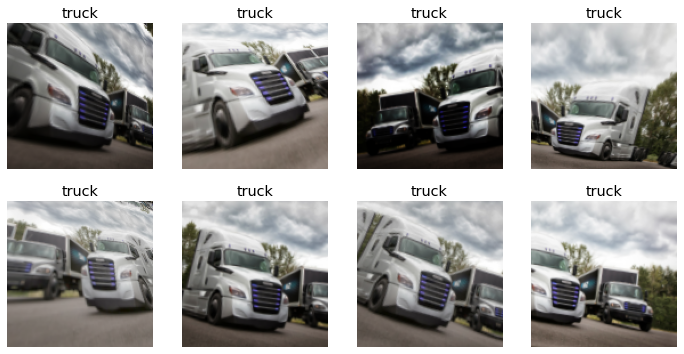

In [60]:
vehicles_dataset = vehicles_dataset.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult = 2))
dls = vehicles_dataset.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique = True)

In [17]:
vehicles_dataset = vehicles_dataset.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = vehicles_dataset.dataloaders(path)

In [30]:
#Creating learner

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.542175,0.188473,0.075829,00:16


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.298773,0.164287,0.071090,00:18
1,0.236256,0.160949,0.047393,00:18
2,0.187785,0.162038,0.047393,00:17
3,0.145339,0.160744,0.033175,00:19


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


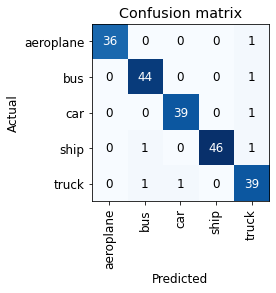

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

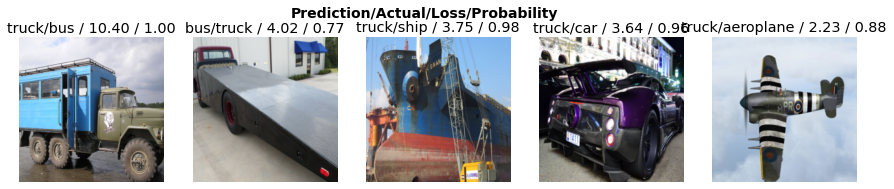

In [20]:
interp.plot_top_losses(5, nrows=1)

In [34]:
#Cleaning data

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [21]:
#Exporting the model

In [26]:
learn.export(fname='vehexport.pkl')

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('vehexport.pkl')]

In [29]:
learn_inf = load_learner(path/'vehexport.pkl')

In [30]:
learn_inf.dls.vocab

['aeroplane', 'bus', 'car', 'ship', 'truck']

In [31]:
#A simple gui

In [36]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'


In [38]:
btn_run.on_click(on_click_classify)

In [39]:
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select your vehicle!'), 
      btn_upload, btn_run, out_pl, lbl_pred])